# <font color='black'>НИС: регрессионный анализ, 2025 </font>
## <font color='black'> Модели с порядковым откликом </font>
В рамках данного практического занятия мы потренируемся в оценивании и интерпретации оценок моделей с порядковым откликом. По мотивам статьи [Joan Esteban, Laura Mayoral, Debraj Ray "Ethnicity and Conflict: an Empirical Study"
American Economic Review 2012, 102(4): 1310–1342] рассмотрим зависимость степени конфликта от таких мер, как поляризация и фракционализация. Ниже представлено краткое описание данных:

* prioInt - «Conflict intensity» from PRIO: we assign a value of 0 if there is peace in a given year, a value of 1 if there is a weak conflict in a given year,
and a value of 2 if there is a strong conflict in a given year
* prioIntLag - Lagged conflict intensity
* f - Fractionalization index (data from Fearon (2003b) and the
Ethnologue project)
* p - Polarization index (Group shares are constructed
as above, for f; data on language and linguistic distances come from
Ethnologue)
* gini - Greenberg-Gini index (Ethnologue; Fearon (2003)
* gpd - Log of real GDP per capita
* pop - Log of population
* mount - Percent mountainous terrain
* ncont - Noncontiguous states, referring to countries with territory holding at
least 10,000 people and separated from the land area containing the
capital city either by land or by 100 kilometers of water

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
from scipy.stats import chi2

In [4]:
lab7 = pd.read_stata('lab_logit.dta')
lab7 = lab7[['prioInt', 'prioIntLag', 'f', 'p', 'gini', 'gdp', 'pop', 'mount', 'ncont']].dropna()

Визуализируем распределение зависимой переменной:

[Text(0, 0, '72.89'), Text(0, 0, '16.62'), Text(0, 0, '10.49')]

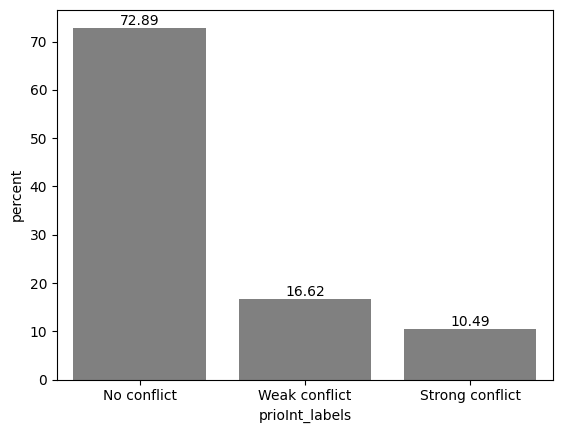

In [5]:
lab7['prioInt_labels'] = lab7['prioInt'].map({0: 'No conflict', 1: 'Weak conflict', 2: 'Strong conflict'})

distr = sns.countplot(x=lab7['prioInt_labels'], color = 'grey', stat = 'percent', order = lab7['prioInt_labels'].value_counts().index)
percent = lab7['prioInt_labels'].value_counts(ascending=False, normalize=True).values * 100
distr.bar_label(container=distr.containers[0], labels=np.round(percent,2))

Перекодируем лагированную переменную prioIntLag в набор дамми для последующего включения в регрессионную модель. И оценим логистическую модель с порядковым откликом

In [6]:
lab7['prioIntLag_no'] = lab7['prioIntLag'].apply(lambda x: 1 if x == 0 else 0)
lab7['prioIntLag_weak'] = lab7['prioIntLag'].apply(lambda x: 1 if x == 1 else 0)

In [7]:
m1_ologit = OrderedModel.from_formula("prioInt ~ prioIntLag_no + prioIntLag_weak + f + p + gini + gdp + pop + mount + ncont", data=lab7, distr = 'logit').fit(cov_type = "HC3", method='bfgs')
print(m1_ologit.summary())

Optimization terminated successfully.
         Current function value: 0.505921
         Iterations: 83
         Function evaluations: 87
         Gradient evaluations: 87
                             OrderedModel Results                             
Dep. Variable:                prioInt   Log-Likelihood:                -569.16
Model:                   OrderedModel   AIC:                             1160.
Method:            Maximum Likelihood   BIC:                             1216.
Date:                Wed, 03 Dec 2025                                         
Time:                        11:31:54                                         
No. Observations:                1125                                         
Df Residuals:                    1114                                         
Df Model:                           9                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------

Проинтерпретируйте оценки коэффициентов в терминах отношения шансов:

In [8]:
odds_ratios = pd.DataFrame(
    {"OR": round(np.exp(m1_ologit.params), 3),
     "p-value": round(m1_ologit.pvalues, 3),
     "Lower CI": round(np.exp(m1_ologit.conf_int()[0]),3),
     "Upper CI": round(np.exp(m1_ologit.conf_int()[1]),3)}
    )

print(odds_ratios)

                      OR  p-value  Lower CI   Upper CI
prioIntLag_no      0.022    0.000     0.012      0.038
prioIntLag_weak    0.226    0.000     0.134      0.381
f                  3.222    0.004     1.458      7.118
p                696.917    0.000    28.870  16823.483
gini               0.006    0.091     0.000      2.219
gdp                0.650    0.000     0.545      0.776
pop                1.095    0.189     0.956      1.255
mount              1.004    0.341     0.996      1.012
ncont              1.677    0.021     1.080      2.605
0.0/1.0            0.058    0.048     0.003      0.972
1.0/2.0            2.056    0.000     1.788      2.365


Проверим, соблюдается ли допущение пропорциональности шансов:

In [9]:
lab7['prioInt_0'] = lab7['prioInt'].apply(lambda x: 1 if x == 0 else 0)
lab7['prioInt_1'] = lab7['prioInt'].apply(lambda x: 1 if x <= 1 else 0)

In [10]:
m1_logit = smf.logit("prioInt_0 ~ prioIntLag_no + prioIntLag_weak  + f + p + gini + gdp + pop + mount + ncont", data=lab7).fit(cov_type = "HC3")
m2_logit = smf.logit("prioInt_1 ~  prioIntLag_no + prioIntLag_weak + f + p + gini + gdp + pop + mount + ncont", data=lab7).fit(cov_type = "HC3")
output = summary_col([m1_logit, m2_logit],stars=True)
print(output)

Optimization terminated successfully.
         Current function value: 0.355272
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.191272
         Iterations 9

                prioInt_0  prioInt_1 
-------------------------------------
Intercept       -1.3794    -3.0620   
                (1.5734)   (2.4145)  
prioIntLag_no   3.3584***  3.8389*** 
                (0.3069)   (0.3673)  
prioIntLag_weak 0.9054***  1.7208*** 
                (0.3297)   (0.2907)  
f               -1.4041*** -0.6821   
                (0.4378)   (0.6295)  
p               -6.7263*** -7.7843***
                (1.9926)   (2.5931)  
gini            4.2165     11.7285** 
                (2.9959)   (5.9664)  
gdp             0.4145***  0.6164*** 
                (0.1032)   (0.1602)  
pop             -0.1317*   -0.0632   
                (0.0792)   (0.1165)  
mount           -0.0058    -0.0032   
                (0.0047)   (0.0058)  
ncont           -0.7857*** -0.3353 

In [11]:
X = lab7[['prioIntLag_no', 'prioIntLag_weak', 'f', 'p', 'gini', 'gdp', 'pop', 'mount', 'ncont']]
y = lab7[['prioInt']]

In [12]:
multinomial_model = sm.MNLogit(y, X)
m1_mlogit = multinomial_model.fit(cov_type = "HC3")

lr_statistic = 2*(m1_mlogit.llf - m1_ologit.llf)

df_diff = m1_mlogit.df_model - m1_ologit.df_model

p_value_lrt = chi2.sf(lr_statistic, df_diff)

print(f"Likelihood Ratio Statistic: {lr_statistic}")
print(f"Degrees of Freedom: {df_diff}")
print(f"P-Value (LRT): {p_value_lrt}")

Optimization terminated successfully.
         Current function value: 0.499967
         Iterations 8
Likelihood Ratio Statistic: 13.397797424162945
Degrees of Freedom: 7.0
P-Value (LRT): 0.06298921412567136


Рассчитаем предсказанные вероятности и классифицируем наблюдения: наблюдение определяется в класс с максимальной вероятностью

In [13]:
y_pred = m1_ologit.predict(X)
y_pred.head()

,0,1,2
0,0.036258,0.190969,0.772772
2,0.686396,0.258375,0.055229
3,0.700893,0.247332,0.051775
4,0.041850,0.212642,0.745509
5,0.036826,0.193244,0.769930


In [14]:
y_class = np.argmax(y_pred, axis = 1)
y_class

array([2, 0, 0, ..., 0, 0, 0])

По результатам предсказания классов на основе модели с порядковым откликом можно, как и в случае модели с бинарным откликом, вывести confusion matrix. Однако меры специфичности и чувствительности считаются для каждого класса отдельно.

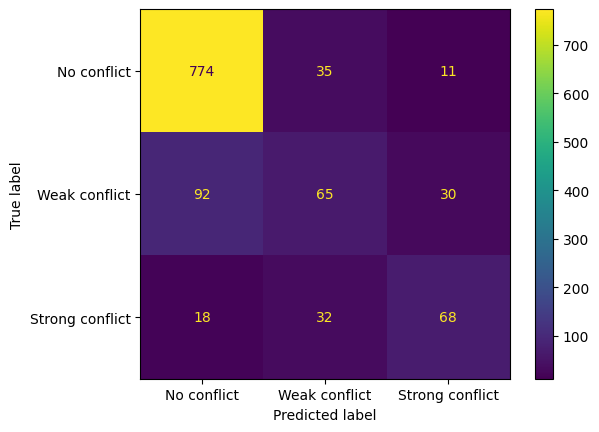

In [15]:
cm = confusion_matrix(y, y_class)
ConfusionMatrixDisplay(confusion_matrix=cm,  display_labels=['No conflict', 'Weak conflict', 'Strong conflict']).plot()

In [16]:
Accuracy = accuracy_score(y, y_class)

Sensitivity_noconflict = recall_score(y, y_class, average = None)[0]
Sensitivity_weak = recall_score(y, y_class, average = None)[1]
Sensitivity_strong = recall_score(y, y_class, average = None)[2]

Specificity_noconflict = (cm[1,1]+cm[1,2]+cm[2,1]+cm[2,2])/(cm[1,1]+cm[1,2]+cm[2,1]+cm[2,2]+cm[1,0]+cm[2,0])
Specificity_weak = (cm[0,0]+cm[0,2]+cm[2,0]+cm[2,2])/(cm[0,0]+cm[0,2]+cm[2,0]+cm[2,2]+cm[0,1]+cm[2,1])
Specificity_strong = (cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1]+cm[0,2]+cm[1,2])

print('Accuracy: {:.3f}'.format(Accuracy))

print('Sensitivity No Conflict: {:.3f}'.format(Sensitivity_noconflict))
print('Specificity No Conflict: {:.3f}'.format(Specificity_noconflict))

print('Sensitivity Weak Conflict: {:.3f}'.format(Sensitivity_weak))
print('Specificity Weak Conflict: {:.3f}'.format(Specificity_weak))

print('Sensitivity Strong Conflict: {:.3f}'.format(Sensitivity_strong))
print('Specificity Strong Conflict: {:.3f}'.format(Specificity_strong))


Accuracy: 0.806
Sensitivity No Conflict: 0.944
Specificity No Conflict: 0.639
Sensitivity Weak Conflict: 0.348
Specificity Weak Conflict: 0.929
Sensitivity Strong Conflict: 0.576
Specificity Strong Conflict: 0.959


In [17]:
y_bin = label_binarize(y,classes=[0, 1, 2])

In [18]:
model = OneVsRestClassifier(LogisticRegression(max_iter = 1000))
model.fit(X, y_bin)
y_prob = model.predict_proba(X)

In [19]:
number_classes = 3

fpr = [0,0,0]
tpr = [0,0,0]
auc_score = [0,0,0]
for i in range(number_classes):
  fpr[i], tpr[i], thresholds = roc_curve(y_bin[:, i],y_prob[:, i])
  auc_score[i] = auc(fpr[i], tpr[i])
print(auc_score)

[np.float64(0.8835585765693722), np.float64(0.7832343249375734), np.float64(0.9214986619090099)]


In [20]:
print(sum(auc_score) / number_classes)

0.8627638544719852


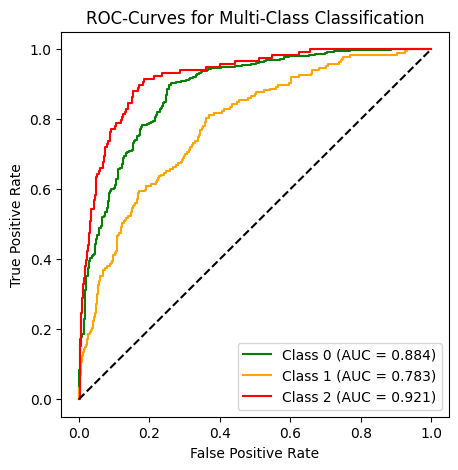

In [21]:
plt.figure(figsize=(5, 5))
colors = ['green', 'orange', 'red']
for i, color in zip(range(number_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'Class {i} (AUC = {auc_score[i]:.3f})')
plt.plot([0, 1], [0, 1], color="black", linestyle="--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curves for Multi-Class Classification')
plt.legend(loc="lower right")
plt.show()